In [ ]:
# TODO
# Create function to get all edge IDs for a given Adm2 Unit

# Create function to extract deforestation data for edge
# - Add weighting option (distance-based from river)
# - Add river width-based weighting option
# - Allow choice between simple buffer and slope-based buffer

# Network model

In [2]:
import pickle
import sqlite3
import shapely
from shapely.geometry import Point, MultiPoint
from sklearn.cluster import MiniBatchKMeans
from tqdm import tqdm
import numpy as np
import pandas as pd
import geopandas as gpd
from multiprocessing import Pool
from collections import defaultdict

# connect to database
conn = sqlite3.connect('/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/imagery/imagery.db')
# get grid data
grid_data = pd.read_sql_query("SELECT * FROM GridCells WHERE Internal=1", conn)
# get grid geometries
grid_geoms = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/imagery/grid_cells.feather")
# merge data
grid_data = gpd.GeoDataFrame(grid_data.merge(grid_geoms, on = "CellID"))
# close connection
conn.close()

i = 525

rivers = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/msc_rivers.feather").to_crs(5641)
rivers_subset = gpd.clip(rivers, grid_data.geometry.iloc[i])

boundaries = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/raw/gadm/gadm41_BRA_2.json", engine = "pyogrio").to_crs(5641)
boundaries_subset = gpd.clip(boundaries, grid_data.geometry.iloc[i])

In [ ]:
rivers["length"] = rivers.length
rivers.sort_values("length", ascending = False, inplace = True)

/scratch/slurm_tmpdir/job_23213442/ipykernel_26566/2942786478.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  rivers["length"] = rivers.length


In [ ]:
test = rivers[(rivers.NORIOCOMP != "Linha de Costa")].simplify(.0001)
test.plot(lw = .1)

---

In [ ]:
# - Explode MultiLineString to LineString
# - Update vertices, nodes
# - Get 
#  - Get indices of coordinates that are node
#  - Get those that are not at end of line
#  - Break line at those indices

In [52]:
def add_intersections_chunk(chunk_data):
    """
    This function add vertices to a chunk of river geometries at the intersections with boundaries.
    It is designed to be used with Pool.map() to process data in parallel.
    
    Parameters
    ----------
    chunk_data : tuple
        A tuple containing a GeoDataFrame of river geometries and a GeoSeries of boundaries.
    
    Returns
    -------
    oshapefile : GeoDataFrame
        A GeoDataFrame containing the river geometries with added vertices.
    ointersections : list
        A list of tuples containing the coordinates of the added vertices.
    """
    chunk, cboundaries_line, cboundaries_polygon = chunk_data
    chunk["intersecting_boundary_ids"] = pd.NA
    ointersections = [None] * len(chunk)
    # get intersections with boundaries
    #cintersections = chunk.intersection(cboundaries)
    # iterate over chunk
    for j in range(len(chunk)):
        # get intersections with boundaries for current geometry
        ccintersections_boundary = gpd.GeoSeries(shapely.intersection(chunk.iloc[j].geometry, cboundaries_line)[0])#cintersections.iloc[j]
        ccintersections_full = gpd.GeoSeries(shapely.intersection(chunk.iloc[j].geometry, cboundaries_polygon)["geometry"])
        # if there are intersections
        if not all(ccintersections_full.is_empty):
            # write all intersecting boundary ids to shapefile
            chunk.at[chunk.index[j], "intersecting_boundary_ids"] = ccintersections_full[~ccintersections_full.is_empty].index.values
        if not all(ccintersections_boundary.is_empty):
            cintersections = []
            # extract points from MultiPoint geometries
            for i in range(len(ccintersections_boundary[~ccintersections_boundary.is_empty])):
                if ccintersections_boundary[~ccintersections_boundary.is_empty].iloc[i].geom_type == "MultiPoint":
                    cintersections += [list(ccintersections_boundary[~ccintersections_boundary.is_empty].iloc[i].geoms)]
                if ccintersections_boundary[~ccintersections_boundary.is_empty].iloc[i].geom_type == "Point":
                    cintersections += [[ccintersections_boundary[~ccintersections_boundary.is_empty].iloc[i]]]
            # create a GeoDataFrame of line points and intersections
            cvertice_points = pd.concat([
                gpd.GeoDataFrame(dict(geometry = [Point(x) for x in chunk.iloc[j].geometry.coords], type = "internal")),
                gpd.GeoDataFrame(dict(geometry = np.concatenate(cintersections), type = "external"))
            ], ignore_index = True)
            ## sort points by distance along line
            # add distance along line to points
            # credit: https://gis.stackexchange.com/a/413748
            cvertice_points['dist_along_line'] = cvertice_points['geometry'].apply(lambda p: chunk.iloc[j].geometry.project(p))
            # sort points by distance along line
            cvertice_points = cvertice_points.sort_values(by='dist_along_line')
            # write back to shapefile
            chunk.loc[chunk.index[j],"geometry"] = shapely.geometry.LineString(cvertice_points['geometry'].values)
            # store border_nodes
            ointersections[j] = [x.coords[0] for x in np.concatenate(cintersections)]
    if not all([x is None for x in ointersections]):
        ointersections = np.concatenate([x for x in ointersections if x is not None])
    else:
        ointersections = []
    return chunk, ointersections

def split_vertice(split_data):
    """
    This function splits a river geometry at the nodes provided.
    It is designed to be used with Pool.map() to process data in parallel.

    Parameters
    ----------
    split_data : tuple
        A tuple containing a GeoSeries of river geometries and a numpy array of indices of nodes to split at.

    Returns
    -------
    cvertice : GeoSeries
        A GeoSeries containing the river geometry with added vertices.
    """
    cvertice, csplit_ids = split_data
    while csplit_ids.size != 0:
        # get node to split at
        if type(cvertice.geometry) == shapely.geometry.linestring.LineString:
            # get coordinates of river
            ccoords = np.array(cvertice.geometry.coords)
            # pop node to split at
            isplit = csplit_ids[0]
            csplit_ids = csplit_ids[1:]
            # split river geometry
            cvertice["geometry"] = shapely.geometry.MultiLineString([shapely.geometry.LineString(ccoords[:isplit+1]), shapely.geometry.LineString(ccoords[(isplit):])])
            # fix indices
            csplit_ids[csplit_ids > isplit] += 1
        elif type(cvertice.geometry) == shapely.geometry.multilinestring.MultiLineString:
            # get coordinates of sub-LineStrings in river
            ccoords = np.concatenate([x.coords for x in cvertice.geometry.geoms])
            # get index of sub-LineString at coord
            csubindex = np.repeat(np.arange(len(cvertice.geometry.geoms)), [len(x.coords) for x in cvertice.geometry.geoms])
            # pop node to split at
            isplit = csplit_ids[0]
            csplit_ids = csplit_ids[1:]
            # fix indices
            csplit_ids[csplit_ids > isplit] += 1
            # get index of sub-LineString to split
            iisplit = csubindex[isplit]
            # get index of node in sub-LineString
            isplit -= np.sum([len(x.coords) for x in list(cvertice.geometry.geoms)[:iisplit]])
            # skip if node is at end of sub-LineString
            if (isplit == 0 or isplit == len(ccoords[csubindex==iisplit]) - 1):
                continue
            # split river geometry
            ccoords = list(cvertice.geometry.geoms)[:iisplit] + [shapely.geometry.LineString(ccoords[csubindex==iisplit][:isplit+1])] +\
                [shapely.geometry.LineString(ccoords[csubindex==iisplit][isplit:])] + list(cvertice.geometry.geoms)[iisplit+1:]
            cvertice["geometry"] = shapely.geometry.MultiLineString([shapely.geometry.LineString(x) for x in ccoords])
    return cvertice

class river_network:
    """
    A class representing a river network.
    """
    def __init__(self, shapefile, boundaries, coastline):
        self.shapefile = shapefile
        self.boundaries = boundaries
        self.coastline = coastline
        self.edges_fl = None
        self.points = None
        self.points_indices = None
        self.network_nodes = None
        self.border_nodes = None
        self.end_nodes = None
        self.nodes = None
        self.nodes_types = None
                
    def explode_rivers(self):
        self.shapefile = self.shapefile.explode(index_parts=True)
        #self.shapefile.index = self.shapefile.index.map(lambda x: x[0] * 100 + x[1])
        
    def update_vertices(self):
        print("*** Updating vertices ***")
        # get vertices as numpy array of line coordinates
        vertices = self.shapefile.geometry.map(lambda x: np.array(x.coords))
        # get first and last vertex of each line
        self.edges_fl = self.shapefile.geometry.map(lambda x: np.array(x.coords)[[0,-1]])
        # get indices of flat list of vertices
        self.points_indices = np.repeat(vertices.index, vertices.map(len))
        # flatten vertices
        self.points = np.vstack(vertices)
        
    def update_nodes(self):
        self.nodes = np.concatenate([self.network_nodes, self.border_nodes, self.end_nodes])
        self.nodes_types = np.concatenate([np.repeat("network", len(self.network_nodes)), np.repeat("border", len(self.border_nodes)), np.repeat("end", len(self.end_nodes))])
        
    def update_network_nodes(self):
        print("*** Updating network nodes ***")
        # get unique points and their counts
        points_counts = np.unique(self.points, return_counts = True, axis = 0)
        # get network nodes (points with more than one occurrence)
        network_nodes = points_counts[0][points_counts[1] > 1]
        # combine nodes and create type array
        self.network_nodes = network_nodes
        
    def update_border_nodes(self):
        print("*** Updating border nodes ***")
        ## split up the shapes into smaller chunks of 10000 geometries
        #   (any speed up here requires the order of geometries in the shapefile to correspond to proximity in space
        #   hence we cluster the geometries to obtain cluster with spatial proximity)
        # extract representative points
        representative_points = self.shapefile.centroid
        coords = np.array(list(zip(representative_points.x, representative_points.y)))
        # perform spatial clustering
        mbkmeans = MiniBatchKMeans(n_clusters=((self.shapefile.shape[0] // 1000) + 1), batch_size=10000, random_state=42)
        cluster_labels = mbkmeans.fit_predict(coords)
        # split the shapefile into chunks
        chunks = [self.shapefile[cluster_labels == i].copy() for i in range(mbkmeans.n_clusters)]

        # a function to expand bounds by a factor
        def expand_bounds(bounds, factor = 1.1):
            return [bounds[0] - (bounds[2] - bounds[0]) * (factor - 1) / 2, bounds[1] - (bounds[3] - bounds[1]) * (factor - 1) / 2, bounds[2] + (bounds[2] - bounds[0]) * (factor - 1) / 2, bounds[3] + (bounds[3] - bounds[1]) * (factor - 1) / 2]
        
        # prepare data for multiprocessing
        data_for_processing = []
        #dissolved_shapefile = self.boundaries.dissolve().boundary#.geometry.iloc[0]
        for chunk in chunks:
            cbounds = expand_bounds(chunk.total_bounds)
            cboundaries_line = gpd.clip(self.boundaries.boundary, cbounds).to_frame()
            cboundaries_polygon = gpd.clip(self.boundaries.geometry, cbounds).to_frame()
            if cboundaries_line.empty:
                continue
            #cboundaries = cboundaries.dissolve().geometry.iloc[0]
            data_for_processing.append((chunk.copy(), cboundaries_line, cboundaries_polygon))

        # use Pool to process data in parallel
        #results = [add_intersections_chunk(data_for_processing[i]) for i in range(8)]
        with Pool(4) as pool:
            results = list(tqdm(pool.imap(add_intersections_chunk, data_for_processing), total=len(data_for_processing), unit="chunk"))
        
        # Post-process results
        # Replace geometries with added vertices
        self.shapefile["intersecting_boundary_ids"] = pd.NA
        self.shapefile.update(pd.concat([x[0] for x in results]))
        # Flatten list of intersections and update `self.border_nodes`
        self.border_nodes = np.concatenate([x[1] for x in results if not x[1] == []])

    def update_end_nodes(self):
        # Note: All estuary nodes are also end nodes
        print("*** Updating end nodes ***")
        # get unique points and their counts
        points_counts = np.unique(self.points, return_counts = True, axis = 0)
        # get those that only appear once
        points_ends = points_counts[0][points_counts[1] == 1]
        ## Get indices of single occurrence points as end candidates
        # Convert arrays to lists of tuples
        points_ends_hashed = [tuple(row) for row in points_ends]
        points_hashed = [tuple(row) for row in self.points]
        # Create a dictionary from elements of the points array to their indices
        dict_points = {elem: i for i, elem in enumerate(points_hashed)}
        # Find matching indices
        points_ends_indices = np.array([dict_points.get(elem, None) for elem in points_ends_hashed])
        ## Get end candidates that are at end of their respective line
        points_ends_reshaped = self.points[points_ends_indices][:, np.newaxis, :]
        edges_fl_subset = np.stack(self.edges_fl.loc[self.points_indices[points_ends_indices]])
        node_external_boolean = np.any(np.all(points_ends_reshaped == edges_fl_subset, axis=2), axis=1)
        # get ends (points with exactly one occurrence at end of line)
        self.end_nodes = self.points[points_ends_indices[node_external_boolean]]
        
    def update_estuary_nodes(self):
        # turn coastline into dictionary for faster lookup
        coastline_dict = {tuple(x): i for i, x in enumerate(np.array(self.coastline.iloc[0].geometry.coords))}
        # get indices of points that are at coastline
        points_coastline_indices = np.array([coastline_dict.get(tuple(x), np.nan) for x in self.points])
        # get estuary nodes
        self.estuary_nodes = self.points[np.logical_not(np.isnan(points_coastline_indices))]
        
    def break_lines_at_nodes(self):
        print("*** Breaking lines at nodes ***")
        ## get indices of points that are nodes
        # create a dictionary from elements of the points array to their indices
        dict_points = defaultdict(list)
        # Iterate over pairs of corresponding tuples from both arrays
        for point, index in zip(self.points, self.points_indices):
            # Convert numpy arrays to tuples for hashing
            point_tuple = tuple(point)
            # Append the index to the list corresponding to the point
            dict_points[point_tuple].append(index)
        # Convert defaultdict to dict if necessary
        mapping_dict = dict(dict_points)
        
        # get indices of nodes with node
        vertices_w_nodes_indices = np.vstack([dict_points.get(elem, np.nan) for elem in [tuple(row) for row in self.nodes]])
        # get unique indices
        vertices_w_nodes_indices = np.unique(vertices_w_nodes_indices, axis = 0)
        # create dictionary from elements of the nodes array to True
        dict_nodes = {tuple(x): True for x in self.nodes}
        
        data_for_processing = []
        for vertice_id in vertices_w_nodes_indices:
            # get the current vertice
            cvertice = self.shapefile.loc[tuple(vertice_id)]
            #
            if type(cvertice.geometry) == shapely.geometry.linestring.LineString:
                cvertice_coordinates = cvertice.geometry.coords
            elif type(cvertice.geometry) == shapely.geometry.linestring.MultiLineString:
                cvertice_coordinates = np.concatenate([x.coords for x in cvertice.geometry.geoms])
            # get the indices of the points that are nodes
            csplit_ids = np.where([dict_nodes.get(x, 0) for x in cvertice_coordinates])[0]
            csplit_ids = csplit_ids[((csplit_ids!=0) &(csplit_ids!=(len(cvertice_coordinates)-1)))]
            # if there are nodes to split at, add to data for processing
            if (not csplit_ids.size == 0):
                data_for_processing.append((cvertice.copy(), csplit_ids))
    
        # use Pool to process data in parallel
        with Pool(4) as pool:
            results = list(tqdm(pool.imap(split_vertice, data_for_processing), total=len(data_for_processing), unit="vertices"))
        #results = [split_vertice(x) for x in data_for_processing[:1000]]
        
        # Replace geometries with added vertices
        self.shapefile.update(pd.DataFrame().from_records(results, index = [x.name for x in results])) 
                
    def clean_shapefile(self):
        # a dict from end point to river end id(s)
        rivers_ends = self.shapefile.copy().geometry.map(lambda x: tuple(np.array(x.coords)[-1]))
        rivers_ends = rivers_ends.reset_index()
        rivers_ends["index"] = rivers_ends[["level_0", "level_1", "level_2"]].apply(tuple, axis = 1)
        rivers_ends_dict = rivers_ends.groupby(rivers_ends["geometry"]).index.apply(list).to_dict()
        # a dict from river id to start point
        rivers_starts = self.shapefile.geometry.map(lambda x: tuple(np.array(x.coords)[0]))
        rivers_starts_dict = dict(zip(rivers_starts.index, rivers_starts))
        # a dict to check if a point is a river source node
        end_nodes_dict = dict(zip([tuple(x) for x in self.end_nodes], range(len(self.end_nodes))))
        # a dict to check if a point is a river network node
        network_nodes_dict = dict(zip([tuple(x) for x in self.network_nodes], range(len(self.network_nodes))))
        # a dict to check if a point is a river border node
        border_nodes_dict = dict(zip([tuple(x) for x in self.border_nodes], range(len(self.border_nodes))))
        # a dict to check if a point is a river estuary node
        coastline_dict = {tuple(x): i for i, x in enumerate(np.array(self.coastline.iloc[0].geometry.coords))}
        
        # prepare a database for nodes
        self.shapefile[["downstream_node_id", "upstream_node_id", "adm2", "estuary", "river", "segment", "subsegment"]] = np.nan
        self.topology = gpd.GeoDataFrame(index = range(len(self.nodes)), columns = ["estuary", "confluence", "source", "border", "geometry"])
        self.topology["estuary"] = np.logical_not(np.isnan(np.array([coastline_dict.get(tuple(x), np.nan) for x in self.nodes])))  # get indices of points that are at coastline
        self.topology["confluence"] = self.nodes_types == "network"
        self.topology["source"] = ((self.nodes_types == "end") & ~(self.nodes_types == "estuary"))
        self.topology["border"] = self.nodes_types == "border"
        self.topology["geometry"] = [Point(x) for x in self.nodes]
        
        # function to parse river
        def worker(edge_id, downstream_node_id, estuary, river, segment, subsegment):
            # get end point of current node
            cend_node = rivers_starts_dict.get(edge_id, [])
            # get adm2 with largest intersection
            if not self.shapefile.loc[edge_id].isna().intersecting_boundary_ids:
                if self.shapefile.loc[edge_id].intersecting_boundary_ids.size > 1:
                    cadm_2 = self.shapefile.loc[edge_id].intersecting_boundary_ids[np.argmax(shapely.intersection(self.shapefile.loc[edge_id].geometry, boundaries.loc[self.shapefile.loc[edge_id].intersecting_boundary_ids].geometry).length)]
                else:
                    cadm_2 = self.shapefile.loc[edge_id].intersecting_boundary_ids
            else:
                cadm_2 = np.nan
            # update topology
            cis_border_node = border_nodes_dict.get(cend_node, None)
            cis_network_node = network_nodes_dict.get(cend_node, None)
            cis_end_node = end_nodes_dict.get(cend_node, None)
            # if end point is a network node
            if cis_network_node is not None:
                cnodeid = cis_network_node
                self.shapefile.loc[edge_id, ["downstream_node_id", "upstream_node_id", "adm2", "estuary", "river", "segment", "subsegment"]] = downstream_node_id, cnodeid, cadm_2, estuary, river, segment, subsegment
                # get all upstream river ids
                cnext_ids = rivers_ends_dict.get(cend_node, [])
                if len(cnext_ids) == 1:
                    # get next river id
                    cnext_id = cnext_ids[0]
                    # recursively update all upstream arms
                    estuary, river, segment, subsegment = worker(cnext_id, cnodeid, estuary, river, segment, subsegment + 1)
                else:
                    # check if there are rivers with the same name
                    same_name = [((self.shapefile.loc[cnext_id].NORIOCOMP == self.shapefile.loc[edge_id].NORIOCOMP) and (self.shapefile.loc[cnext_id].NORIOCOMP is not None)) for cnext_id in cnext_ids]
                    # get first river with same name
                    # Find the index of the first True value
                    if any(same_name):
                        start_index = same_name.index(True)
                    else:
                        start_index = 0
                    # Loop over items starting from the first True item, wrapping around as needed
                    for i in range(len(cnext_ids)):
                        # Calculate the current index, wrapping around using modulo
                        current_index = (start_index + i) % len(cnext_ids)
                        # if we are at the start index, maintain river id
                        if current_index == start_index:
                            estuary, river, segment, subsegment = worker(cnext_ids[current_index], cnodeid, estuary, river, segment + 1, 0)
                        # else increase river id
                        else:
                            estuary, river, segment, subsegment = worker(cnext_ids[current_index], cnodeid, estuary, river + 1, 0, 0)
            # if end point is a border node
            elif cis_border_node is not None:
                cnodeid = len(self.network_nodes) + cis_border_node
                self.shapefile.loc[edge_id, ["downstream_node_id", "upstream_node_id", "adm2", "estuary", "river", "segment", "subsegment"]] = downstream_node_id, cnodeid, cadm_2, estuary, river, segment, subsegment
                # get next river id
                cnext_id = rivers_ends_dict.get(cend_node, [])[0]
                # recursively update all upstream arms
                estuary, river, segment, subsegment = worker(cnext_id, cnodeid, estuary, river, segment + 1, 0)
            # if end point is a end node, return
            elif cis_end_node is not None:
                cnodeid = len(self.network_nodes) + len(self.border_nodes) + cis_end_node
                self.shapefile.loc[edge_id, ["downstream_node_id", "upstream_node_id", "adm2", "estuary", "river", "segment", "subsegment"]] = downstream_node_id, cnodeid, cadm_2, estuary, river, segment, subsegment
            return estuary, river, segment, subsegment
        
        # iterate over estuary nodes
        for i in tqdm(range(len(self.estuary_nodes))):#
            init_vertice = rivers_ends_dict.get(tuple(self.estuary_nodes[i]), [])[0]
            worker(init_vertice, np.nan, i, 0, 0, 0)
                
    def store_network(self, path):
        self.shapefile[["NORIOCOMP", "CORIO", "downstream_node_id", "upstream_node_id", "adm2", "estuary", "river", "segment", "subsegment", "geometry"]].to_feather(path + "shapefile.feather")
        self.topology.to_feather(path + "topology.feather")
        with open(path + "network.pkl", "wb") as f:
            pickle.dump(self, f)

In [53]:
rivers_brazil = river_network(rivers[(rivers.NORIOCOMP != "Linha de Costa")],
                              boundaries,
                              rivers[(rivers.NORIOCOMP == "Linha de Costa")])
# explode multi-geometries
rivers_brazil.explode_rivers()
rivers_brazil.update_vertices()
# compute nodes
rivers_brazil.update_network_nodes()
rivers_brazil.update_border_nodes() # (multiprocessing-enabled: est. 4min)
rivers_brazil.update_end_nodes()
rivers_brazil.update_vertices()
rivers_brazil.update_nodes()

# break lines at nodes
rivers_brazil.break_lines_at_nodes() # (multiprocessing-enabled: est. 10min)
rivers_brazil.explode_rivers()
rivers_brazil.update_vertices()
# clean shapefile
rivers_brazil.update_estuary_nodes()
rivers_brazil.clean_shapefile()
rivers_brazil.store_network("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/")

*** Updating vertices ***
*** Updating network nodes ***
*** Updating border nodes ***


100%|██████████| 138/138 [08:22<00:00,  3.64s/chunk]
/scratch/slurm_tmpdir/job_23279288/ipykernel_235531/881574475.py:197: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  self.border_nodes = np.concatenate([x[1] for x in results if not x[1] == []])


*** Updating end nodes ***
*** Updating vertices ***


---

In [57]:
rivers_brazil_shapefile = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/shapefile.feather")
rivers_brazil_topology = gpd.read_feather("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/misc/topology.feather")

In [ ]:
# TODO: Produce plots

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (10,10))
rivers_brazil_shapefile.plot(ax = ax, column = "estuary", cmap = "tab20", linewidth = .1)
rivers_brazil_shapefile[rivers_brazil_shapefile.estuary.isna()].plot(ax = ax, color = "black", linewidth = .1)

In [ ]:
nodes_counts = np.unique(subset.points, return_counts = True, axis = 0)

<Axes: >

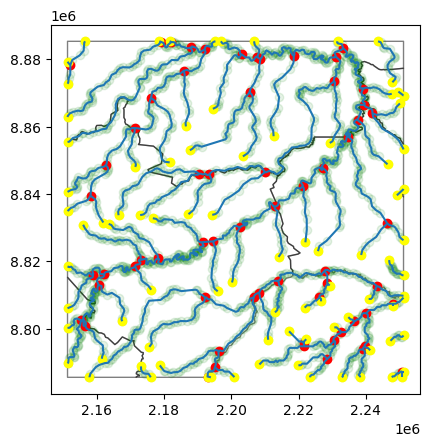

In [ ]:
ax = rivers_subset.plot()
boundaries_subset.plot(ax = ax, edgecolor = "black", color = "None", alpha = .5)
gpd.GeoSeries([shapely.geometry.Point(x) for x in nodes_counts[0][nodes_counts[1] == 1]]).plot(ax = ax, color = "green", alpha = .1)
#gpd.GeoSeries([shapely.geometry.Point(x) for x in nodes_counts[0][nodes_counts[1] == 2]]).plot(ax = ax, color = "purple")
gpd.GeoSeries([shapely.geometry.Point(x) for x in nodes_counts[0][nodes_counts[1] > 2]]).plot(ax = ax, color = "red")
gpd.GeoSeries([shapely.geometry.Point(x) for x in subset.ends]).plot(ax = ax, color = "yellow")

<Axes: >

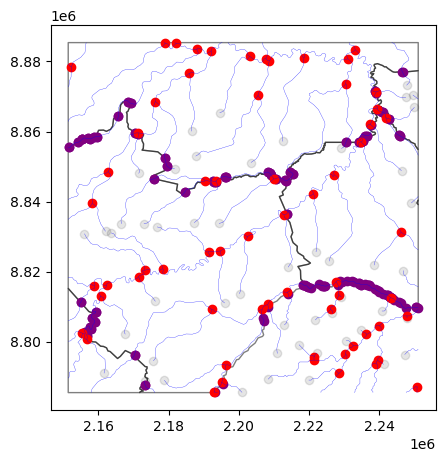

In [66]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (5,5))
gpd.clip(rivers_brazil_shapefile, grid_data.geometry.iloc[[i]].total_bounds).plot(ax = ax, linewidth = .2, edgecolor = "blue")
boundaries_subset.plot(ax = ax, edgecolor = "black", color = "None", alpha = .5)
gpd.clip(gpd.GeoSeries(np.apply_along_axis(Point, 1, rivers_brazil.end_nodes)), grid_data.geometry.iloc[[i]].total_bounds).plot(ax = ax, color = "black", alpha = .1)
gpd.clip(gpd.GeoSeries(np.apply_along_axis(Point, 1, rivers_brazil.border_nodes)), grid_data.geometry.iloc[[i]].total_bounds).plot(ax = ax, color = "purple")
gpd.clip(gpd.GeoSeries(np.apply_along_axis(Point, 1, rivers_brazil.network_nodes)), grid_data.geometry.iloc[[i]].total_bounds).plot(ax = ax, color = "red")

In [ ]:
rivers_brazil_shapefile[~rivers_brazil_shapefile.estuary.isna()].plot(column="adm2", lw=.1)

In [151]:
dict_points = defaultdict(list)
# Iterate over pairs of corresponding tuples from both arrays
for point, index in zip(rivers_brazil_shapefile.dropna(subset = "downstream_node_id").downstream_node_id.astype(np.int32), rivers_brazil_shapefile.dropna(subset = "downstream_node_id").index):
    # Append the index to the list corresponding to the point
    dict_points[point].append(index)
# Convert defaultdict to dict if necessary
downstream_lookup = dict(dict_points)

In [105]:
upstream_lookup = {key: value for key, value in zip(rivers_brazil_shapefile.dropna(subset = "upstream_node_id").index, rivers_brazil_shapefile.dropna(subset = "upstream_node_id").upstream_node_id.astype(np.int32))}

In [178]:
end_node_lookup = {x: True for x in rivers_brazil_topology[rivers_brazil_topology.source & ~rivers_brazil_topology.estuary].index}

In [115]:
rivers_brazil_shapefile.query(f"estuary=={query[0]} & river=={query[1]} & segment=={query[2]}")

,,,NORIOCOMP,CORIO,downstream_node_id,upstream_node_id,adm2,estuary,river,segment,subsegment,geometry
42141,0,614,Rio Paranapanema,864_0,157960.0,75413.0,3110.0,228.0,8528.0,72.0,0.0,"LINESTRING (4011743.158 7431655.414, 4011729.0..."


<Axes: >

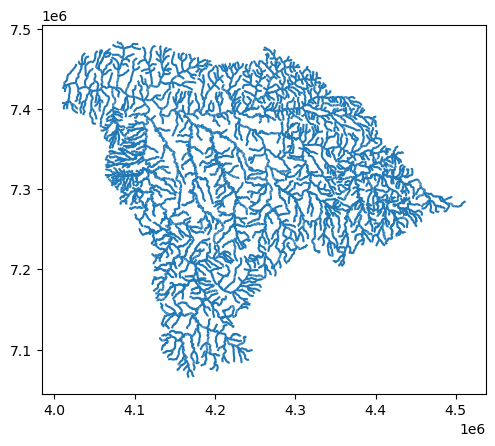

In [203]:
rivers_brazil_shapefile.loc[out].plot()

In [201]:
query = [rivers_brazil_shapefile[rivers_brazil_shapefile.adm2 == 3110].groupby(["estuary", "river"], as_index = False).segment.idxmin().segment.iloc[0]]
out = []
while query:
    tmp = upstream_lookup[query.pop()]
    if not end_node_lookup.get(tmp, False):
        tmp = downstream_lookup[tmp]
        out += tmp
        query += tmp

<Axes: >

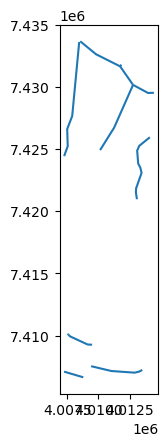

In [81]:
rivers_brazil_shapefile[rivers_brazil_shapefile.adm2 == 3110].plot()

---

# Drainage Model

In [ ]:
# TODO: Formalize these downloads

In [74]:
import urllib
urllib.request.urlretrieve("https://opendata.arcgis.com/api/v3/datasets/4c606c38ee534b84bffe70ca6c8552c6_0/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1", "/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage_trench.geojson")

('/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage_trench.geojson',
 <http.client.HTTPMessage at 0x152f9ec48880>)

In [75]:
urllib.request.urlretrieve("https://opendata.arcgis.com/api/v3/datasets/2f54775d2229431bad6a41daf3ed04d8_0/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1", "/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage_area.geojson")

('/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage_area.geojson',
 <http.client.HTTPMessage at 0x152f9ecb6220>)

In [76]:
urllib.request.urlretrieve("https://opendata.arcgis.com/api/v3/datasets/5b97dc790ebc4307938d8a5b089c1aab_0/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1", "/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage_trenches.geojson")


('/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage_trenches.geojson',
 <http.client.HTTPMessage at 0x152f9eca1910>)

In [78]:
test = gpd.read_file("/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/data/drainage_trenches.geojson", engine="pyogrio")

In [79]:
test

,OBJECTID,ID,COTRECHO,COCURSODAG,COBACIA,NUCOMPTREC,NUDISTBACT,NUDISTCDAG,NUAREACONT,NUAREAMONT,...,NUORDEMCDA,NUCOMPCDA,NUNIVOTTO,NUNIVOTCDA,NUSTRAHLER,DEDOMINIAL,DSVERSAO,TNACIONAL,SHAPE_Length,geometry
0,1,50160,50160,None,93,1102.003699,NaN,NaN,104747.047340,104747.047340,...,NaN,NaN,2,NaN,NaN,Linha de Costa,BHO bho_2017_v_01_05_5k de 2018-06-20,0,11.479881,"MULTILINESTRING ((-62.15593 -39.38203, -62.155..."
1,2,3303825,3303825,None,35,4.721952,NaN,NaN,2.352449,2.352449,...,NaN,NaN,2,NaN,NaN,Linha de Costa,BHO ilha_mexiana de 2018-02-19,0,0.042475,"MULTILINESTRING ((-49.57455 0.07924, -49.57500..."
2,3,3304042,3304042,None,973,1.170633,NaN,NaN,0.394405,0.394405,...,NaN,NaN,3,NaN,NaN,Linha de Costa,BHO ilha_caviana_de_fora de 2018-02-20,1,0.010528,"MULTILINESTRING ((-49.57113 0.28340, -49.57414..."
3,4,3304046,3304046,None,1115,4.465403,NaN,NaN,2.767990,2.767990,...,NaN,NaN,4,NaN,NaN,Linha de Costa,BHO ilha_caviana_de_fora de 2018-02-20,1,0.040162,"MULTILINESTRING ((-49.62472 0.36304, -49.61984..."
4,5,3304044,3304044,None,11113,0.727614,NaN,NaN,0.225937,0.225937,...,NaN,NaN,5,NaN,NaN,Linha de Costa,BHO ilha_caviana_de_fora de 2018-02-20,1,0.006546,"MULTILINESTRING ((-49.56746 0.36666, -49.56650..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464062,464063,122246,122246,None,77997311,65.893703,NaN,NaN,238.728329,238.728329,...,NaN,NaN,8,NaN,NaN,Linha de Costa,BHO bho_2017_v_01_05_5k de 2018-06-20,1,0.649194,"MULTILINESTRING ((-51.54404 -31.76413, -51.544..."
464063,464064,137556,137556,774176,774176913,3.082342,455.331840,49.590287,6.159381,425.759261,...,2.0,88.254017,9,6.0,3.0,Estadual,BHO bho_2017_v_01_05_5k de 2018-06-20,1,0.027734,"MULTILINESTRING ((-41.46475 -16.93666, -41.464..."
464064,464065,430340,430340,6411324,64113241,0.370044,811.367615,0.000000,0.197901,97.119867,...,4.0,19.156837,8,7.0,2.0,Estadual,BHO bho_2017_v_01_05_5k de 2018-06-20,1,0.003339,"MULTILINESTRING ((-47.93699 -5.35312, -47.9368..."
464065,464066,82481,82481,4816,4816513,1.402432,1734.370391,161.123838,8.987300,8036.068845,...,3.0,458.060851,7,4.0,4.0,Estadual,BHO bho_2017_v_01_05_5k de 2018-06-20,1,0.012573,"MULTILINESTRING ((-62.11536 -2.08898, -62.1080..."


In [ ]:
# TODO: Create matching between basins and river -> cut subpolygons with river segments

---

# Water Quality Measurements

In [ ]:
# download template:
"https://www.snirh.gov.br/hidroweb/rest/api/documento/download/files?tipodocumento=csv&codigoestacao=10010000&forcenewfiles=N"

In [ ]:
# TODO: Get list of stations and scrape data

---

# Other

In [ ]:
import ctypes
import numpy as np

j = 23

# Load the shared library
lib = ctypes.CDLL('/pfs/work7/workspace/scratch/tu_zxobe27-master_thesis/code/analysis/deforestation_extract.so')

# Define the argument and return types for the function
lib.calculatePolygons.argtypes = [
    ctypes.POINTER(ctypes.c_double), 
    ctypes.POINTER(ctypes.c_double), 
    ctypes.c_int, 
    ctypes.c_double, 
    ctypes.POINTER(ctypes.POINTER(ctypes.c_double)), 
    ctypes.POINTER(ctypes.POINTER(ctypes.c_double))
]
lib.calculatePolygons.restype = None

# Define the input data
X, Y = np.array(rivers_subset.geometry.iloc[j].coords.xy, dtype = np.double)
distance = 1000
N = len(X)

# Call the C++ function
polygonsX_ptr = ctypes.POINTER(ctypes.c_double)()
polygonsY_ptr = ctypes.POINTER(ctypes.c_double)()
lib.calculatePolygons(
    X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)), 
    Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)), 
    N, 
    distance, 
    ctypes.byref(polygonsX_ptr), 
    ctypes.byref(polygonsY_ptr)
)

# Convert the output to numpy arrays
polygonsX = np.ctypeslib.as_array(polygonsX_ptr, shape=(N - 3, 6))
polygonsY = np.ctypeslib.as_array(polygonsY_ptr, shape=(N - 3, 6))

test = np.array([shapely.geometry.Polygon([(polygonsX[i][j], polygonsY[i][j]) for j in range(6)]) for i in range(N - 3)])

# Free the allocated memory
lib.free(polygonsX_ptr)
lib.free(polygonsY_ptr)

0

<Axes: >

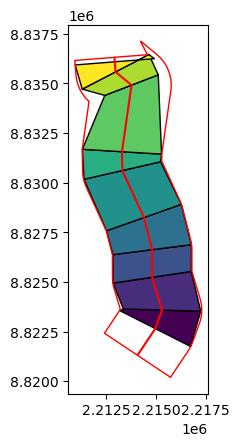

In [ ]:
test_series = gpd.GeoSeries(test).reset_index()
ax = rivers_subset.iloc[[j]].plot(color = "red")
test_series.plot(ax = ax, edgecolor = "black", column = "index")
rivers_subset.iloc[[j]].buffer(2 * 1000, cap_style = "flat").plot(edgecolor = "red", color = "none", ax = ax)
